In [1]:
import torch
import matplotlib.pyplot as plt

from vmp import VMP

from PIL import Image
import io

from utils import display_video

In [2]:
import numpy as np

def rotation_matrix_z(angle_deg):
    """
    Generates a rotation matrix for a rotation around the z-axis.
    :param angle_deg: Angle in degrees to rotate.
    :return: 3x3 rotation matrix.
    """
    angle_rad = np.radians(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    return np.array([
        [cos_a, -sin_a, 0],
        [sin_a, cos_a, 0],
        [0, 0, 1]
    ])

def rotation_matrix_y(angle_deg):
    """
    Generates a rotation matrix for a rotation around the y-axis.
    :param angle_deg: Angle in degrees to rotate.
    :return: 3x3 rotation matrix.
    """
    angle_rad = np.radians(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    return np.array([
        [cos_a, 0, sin_a],
        [0, 1, 0],
        [-sin_a, 0, cos_a]
    ])

def rotation_matrix_x(angle_deg):
    """
    Generates a rotation matrix for a rotation around the x-axis.
    :param angle_deg: Angle in degrees to rotate.
    :return: 3x3 rotation matrix.
    """
    angle_rad = np.radians(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    return np.array([
        [1, 0, 0],
        [0, cos_a, -sin_a],
        [0, sin_a, cos_a]
    ])

In [3]:
class Sphere(object):
    def __init__(self):
        self.radius = 0.98

    def add_sphere(self, ax):
        u = torch.linspace(0, 2 * torch.pi, 100)
        v = torch.linspace(0, torch.pi, 100)
        x_sphere = self.radius * torch.outer(torch.cos(u), torch.sin(v))
        y_sphere = self.radius * torch.outer(torch.sin(u), torch.sin(v))
        z_sphere = self.radius * torch.outer(torch.ones_like(u), torch.cos(v))
        
        ax.plot_surface(
            x_sphere.numpy(), 
            y_sphere.numpy(), 
            z_sphere.numpy(),
            color='gray', alpha=0.3
        )
        
        ax.set_aspect('equal')
        # ax.axis('off')
        
    def add_coordinates(self, ax):
        ax.set_xlim(-3.141592, 3.141592)
        ax.set_ylim(3.141592, 0)
        ax.set_aspect('equal')
        # ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False)

    def ambinet2coordinates(self, x: torch.Tensor):
        """r
        x: [batch_size, 3]
        x = sin(theta)cos(phi), sin(theta)sin(phi), cos(theta)
        """
        x1 = x[:, 0:1]
        x2 = x[:, 1:2]
        x3 = x[:, 2:3]
        theta = torch.acos(x3.clamp(-1+1.0e-8, 1-1.0e-8)).clamp(0, 3.141592)
        phi = torch.atan2(x2, x1)
        z = torch.cat([theta, phi], dim=1)
        return z

    def coordinates2ambient(self, z: torch.Tensor):
        """
        z: [batch_size, 2]
        z = theta, phi
        """
        theta = z[:, 0:1]
        phi = z[:, 1:2]
        x1 = torch.sin(theta) * torch.cos(phi)
        x2 = torch.sin(theta) * torch.sin(phi)
        x3 = torch.cos(theta)
        return torch.cat([x1, x2, x3], dim=1)

In [109]:
sphere = Sphere()

A = 2.6

###### Traj 1
n_samples = 1000
t = torch.linspace(-3.141592, 3.141592, n_samples).view(-1, 1)
x = t
y = A*torch.sin(t)

rotation_z = rotation_matrix_x(-60)  
rotation_y = rotation_matrix_y(-25)  
rotation_combined = np.dot(rotation_y, rotation_z)

trajs = torch.cat([
    1*x, 
    1*y, 
    torch.ones_like(x)
], dim=1).unsqueeze(0)@torch.tensor(
    rotation_combined, 
    dtype=torch.float32).view(-1, 3, 3)
trajs1 = trajs/trajs.norm(dim=-1, keepdim=True)

###### Traj 2
y = -A*torch.sin(t)

rotation_z = rotation_matrix_x(-60)
rotation_y = rotation_matrix_y(-25)
rotation_combined = np.dot(rotation_y, rotation_z)

trajs = torch.cat([
    1*x, 
    1*y, 
    torch.ones_like(x)
], dim=1).unsqueeze(0)@torch.tensor(
    rotation_combined, 
    dtype=torch.float32).view(-1, 3, 3)
trajs2 = trajs/trajs.norm(dim=-1, keepdim=True)

###### concat trajs
trajs = torch.cat([trajs1, trajs2], dim=0)
z_trajs = sphere.ambinet2coordinates(trajs.view(-1, 3)).view(2, -1, 2)

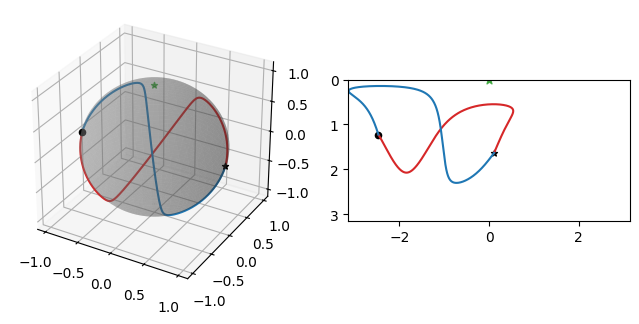

In [110]:
fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sphere.add_sphere(ax1)
ax1.plot(trajs[0, :, 0], trajs[0, :, 1], trajs[0, :, 2], c='tab:red')
ax1.plot(trajs[1, :, 0], trajs[1, :, 1], trajs[1, :, 2], c='tab:blue')
ax1.scatter(trajs[0, 0, 0], trajs[0, 0, 1], trajs[0, 0, 2], c='k', marker='o', s=20, label='initial')
ax1.scatter(trajs[0, -1, 0], trajs[0, -1, 1], trajs[0, -1, 2], c='k', marker='*', s=20, label='final')
ax1.scatter(0, 0, 1, c='tab:green', alpha=0.8, marker='*')

ax2 = fig.add_subplot(1, 2, 2)
sphere.add_coordinates(ax2)
ax2.plot(z_trajs[0, :, 1], z_trajs[0, :, 0], c='tab:red')
ax2.plot(z_trajs[1, :, 1], z_trajs[1, :, 0], c='tab:blue')
ax2.scatter(z_trajs[0, 0, 1], z_trajs[0, 0, 0], c='k', marker='o', s=20, label='initial')
ax2.scatter(z_trajs[0, -1, 1], z_trajs[0, -1, 0], c='k', marker='*', s=20, label='final')
ax2.scatter(0, 0, c='tab:green', alpha=0.8, marker='*')

plt.show()

In [111]:
b = 30
h_mul = 1
dim = 2
via_points = [z_trajs[0, 0, :], z_trajs[0, -1, :]]
model_vmp = VMP(
    b=b,
    h_mul=h_mul,
    dim=dim,
    via_points=via_points,
    num_curves=2
    )
w = model_vmp.LfD(z_trajs)
model_vmp.set_w(w)

c:\Users\21448\Desktop\repos\RiemGeomCurves\vmp.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init = torch.tensor(self.via_points[0], dtype=torch.float32).to(trajs).view(1, 1, dim) # (1, 1, dim)
c:\Users\21448\Desktop\repos\RiemGeomCurves\vmp.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final = torch.tensor(self.via_points[-1], dtype=torch.float32).to(trajs).view(1, 1, dim) # (1, 1, dim)


#### 1. Euclidean interpolation in w

In [ ]:
n_interpolation = 11
w_traj = torch.cat([w[0:1]*(1-t) + w[1:2]*t for t in torch.linspace(0, 1, n_interpolation)], dim=0)
model_vmp = VMP(
    b=b,
    h_mul=h_mul,
    dim=dim,
    via_points=via_points,
    num_curves=n_interpolation
    )

model_vmp.set_w(w_traj)
t = torch.linspace(0, 1, 500).view(1, -1, 1)
z_trajs = model_vmp(t)

trajs = sphere.coordinates2ambient(z_trajs.view(-1, 2)).view(-1, 500, 3)
z_trajs = sphere.ambinet2coordinates(trajs.view(-1, 3)).view(-1, 500, 2)

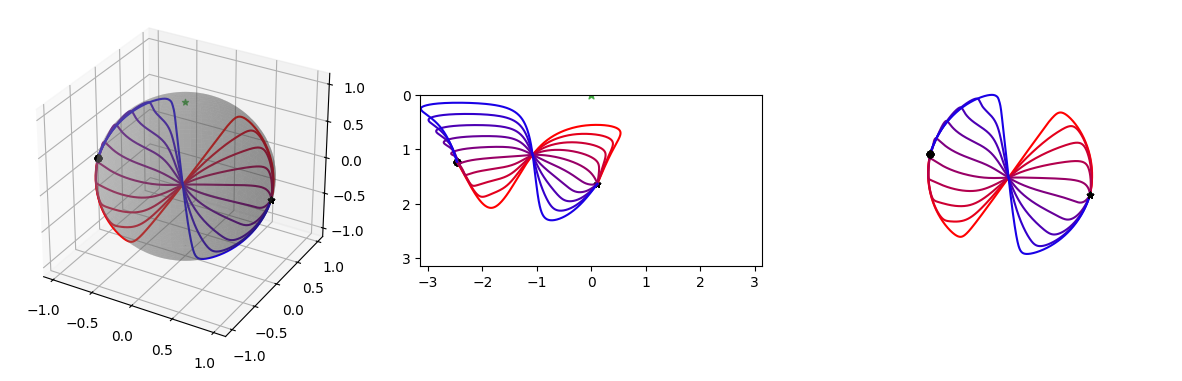

In [114]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
sphere.add_sphere(ax1)

for i in range(len(trajs)):
    progress = i / len(trajs)
    ax1.plot(trajs[i, :, 0], trajs[i, :, 1], trajs[i, :, 2], c=[1-progress, 0, progress])
    ax1.scatter(trajs[i, 0, 0], trajs[i, 0, 1], trajs[i, 0, 2], c='k', marker='o', s=20, label='initial')
    ax1.scatter(trajs[i, -1, 0], trajs[i, -1, 1], trajs[i, -1, 2], c='k', marker='*', s=20, label='final')
ax1.scatter(0, 0, 1, c='tab:green', alpha=0.8, marker='*')

ax2 = fig.add_subplot(1, 3, 2)
sphere.add_coordinates(ax2)
for i in range(len(z_trajs)):
    progress = i / len(z_trajs)
    ax2.plot(z_trajs[i, :, 1], z_trajs[i, :, 0], c=[1-progress, 0, progress])
    ax2.scatter(z_trajs[i, 0, 1], z_trajs[i, 0, 0], c='k', marker='o', s=20, label='initial')
    ax2.scatter(z_trajs[i, -1, 1], z_trajs[i, -1, 0], c='k', marker='*', s=20, label='final')
ax2.scatter(0, 0, c='tab:green', alpha=0.8, marker='*')

ax0 = fig.add_subplot(1, 3, 3, projection='3d')
for i in range(len(trajs)):
    progress = i / len(trajs)
    ax0.plot(trajs[i, :, 0], trajs[i, :, 1], trajs[i, :, 2], c=[1-progress, 0, progress])
    ax0.scatter(trajs[i, 0, 0], trajs[i, 0, 1], trajs[i, 0, 2], c='k', marker='o', s=20, label='initial')
    ax0.scatter(trajs[i, -1, 0], trajs[i, -1, 1], trajs[i, -1, 2], c='k', marker='*', s=20, label='final')
ax0.axis('off')
ax0.axis('equal')

plt.show()

#### To generate video

In [115]:
W_ = torch.cat([w[0:1]*(1-t) + w[1:2]*t for t in torch.linspace(0, 1, 101)], dim=0)
model_vmp.set_w(W_)
t = torch.linspace(0, 1, 500).view(1, -1, 1)
z_trajs = model_vmp(t)

trajs = sphere.coordinates2ambient(z_trajs.view(-1, 2)).view(-1, 500, 3).detach().cpu()
z_trajs = sphere.ambinet2coordinates(trajs.view(-1, 3)).view(-1, 500, 2).detach().cpu()

video = []
for i in range(len(trajs)):
    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    sphere.add_sphere(ax1)

    
    progress = i / len(trajs)
    ax1.plot(trajs[i, :, 0], trajs[i, :, 1], trajs[i, :, 2], c=[1-progress, 0, progress])
    ax1.scatter(trajs[i, 0, 0], trajs[i, 0, 1], trajs[i, 0, 2], c='k', marker='o', s=20, label='initial')
    ax1.scatter(trajs[i, -1, 0], trajs[i, -1, 1], trajs[i, -1, 2], c='k', marker='*', s=20, label='final')
    ax1.scatter(0, 0, 1, c='tab:green', alpha=0.8, marker='*')

    ax2 = fig.add_subplot(1, 2, 2)
    sphere.add_coordinates(ax2)

    ax2.plot(z_trajs[i, :, 1], z_trajs[i, :, 0], c=[1-progress, 0, progress])
    ax2.scatter(z_trajs[i, 0, 1], z_trajs[i, 0, 0], c='k', marker='o', s=20, label='initial')
    ax2.scatter(z_trajs[i, -1, 1], z_trajs[i, -1, 0], c='k', marker='*', s=20, label='final')
    ax2.scatter(0, 0, c='tab:green', alpha=0.8, marker='*')

    # Save the figure to a buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')  # Save to a buffer as a PNG image
    buf.seek(0)  # Rewind the buffer

    # Load the buffer into a PIL image and convert to NumPy array
    image = Image.open(buf)
    image_array = np.array(image)  # Convert to a NumPy array
    buf.close()  # Close the buffer

    video.append(image_array)
    plt.close()

In [116]:
display_video(video, framerate=20)

#### 2. Geodesic interpolation in w with G(w)

In [117]:
model_vmp = VMP(
    b=b,
    h_mul=h_mul,
    dim=dim,
    via_points=via_points,
    num_curves=len(w)
)

def H(z):
    theta = z[:, 0:1]
    phi = z[:, 1:2]
    sin_theta = torch.sin(theta)
    return torch.cat([
        torch.cat([
            torch.ones_like(theta).unsqueeze(-1),
            torch.zeros_like(theta).unsqueeze(-1)
        ], dim=1),
        torch.cat([
            torch.zeros_like(phi).unsqueeze(-1),
            sin_theta.unsqueeze(-1)**2
        ], dim=1)
    ], dim=-1)

def energy(w):
    model_vmp.set_w(w)
    G = model_vmp.get_Riemannian_metric(H, num=100) # len, b, dim, b, dim
    dw = (w[1:] - w[:-1]) # len-1, b, dim
    return torch.einsum('nij, nkl, nijkl -> n', dw, dw, G[:-1]).sum()

In [118]:
load_pretrained = False
if load_pretrained: 
    loss_traj = np.load('results/loss_traj.npy').tolist()
    W = torch.autograd.Variable(torch.tensor(np.load("results/W.npy"), dtype=torch.float32), requires_grad=True)
else:
    loss_traj = []
    w_init_traj = torch.cat([w[0:1]*(1-t) + w[1:2]*t for t in torch.linspace(0, 1, 101)], dim=0)
    W = torch.autograd.Variable(w_init_traj, requires_grad=True)
print(f"Energy: {energy(W)}")

Energy: 0.023714579641819


In [119]:
if load_pretrained:
    max_iter = 10
else:
    max_iter = 1000000

for iter_ in range(max_iter):
    if iter_ > max_iter/2:
        step_sizes = [1e-4, 1e-5, 1e-6]
    else:
        step_sizes = [1, 1e-1, 1e-2, 1e-3]
    loss = energy(W)  # Compute the current loss
    loss_traj.append(loss.detach().cpu().item())  # Track loss over iterations
    
    loss.backward()  # Compute the gradient

    # Normalize the gradient for steepest descent
    grad_norm = W.grad[1:-1].norm(p=2)
    if grad_norm > 0:
        normalized_grad = W.grad[1:-1] / grad_norm
    else:
        normalized_grad = W.grad[1:-1].clone()

    # Line search over all predefined step sizes
    best_step_size = None
    best_loss = float('inf')
    for candidate_step in step_sizes:
        new_W = W.data[1:-1] - candidate_step * normalized_grad  # Test new parameters
        new_loss = energy(new_W)  # Compute loss for the new parameters
        
        # Keep track of the best step size and corresponding loss
        if new_loss < best_loss:
            best_loss = new_loss
            best_step_size = candidate_step

    # If no step size improves the loss, skip the update
    if best_step_size is None:
        print(f"[Iter {iter_+1}] No improvement in loss. Skipping update.")
        W.grad.zero_()
        continue

    # Update the parameters using the best step size
    W.data[1:-1] -= best_step_size * normalized_grad

    # Clear the gradients
    W.grad.zero_()
    if iter_ % 100 == 0:
        print(f"[Iter {iter_+1}] Loss: {loss.detach().cpu().item()}, Best step size: {best_step_size}")
        np.save('results/loss_traj.npy', np.array(loss_traj))
        np.save('results/W.npy', W.detach().cpu())

[Iter 1] Loss: 0.023714579641819, Best step size: 1
[Iter 101] Loss: 0.02358759008347988, Best step size: 0.01
[Iter 201] Loss: 0.023479631170630455, Best step size: 0.01
[Iter 301] Loss: 0.02344757877290249, Best step size: 0.01
[Iter 401] Loss: 0.023418165743350983, Best step size: 0.01
[Iter 501] Loss: 0.02339097112417221, Best step size: 0.01
[Iter 601] Loss: 0.023365680128335953, Best step size: 0.01
[Iter 701] Loss: 0.023342018947005272, Best step size: 0.01
[Iter 801] Loss: 0.023319782689213753, Best step size: 0.01
[Iter 901] Loss: 0.023298798128962517, Best step size: 0.01
[Iter 1001] Loss: 0.023278919979929924, Best step size: 0.01
[Iter 1101] Loss: 0.02326003462076187, Best step size: 0.01
[Iter 1201] Loss: 0.0232420414686203, Best step size: 0.01
[Iter 1301] Loss: 0.023224858567118645, Best step size: 0.01
[Iter 1401] Loss: 0.023208413273096085, Best step size: 0.01
[Iter 1501] Loss: 0.023192644119262695, Best step size: 0.01
[Iter 1601] Loss: 0.023177504539489746, Best ste

KeyboardInterrupt: 

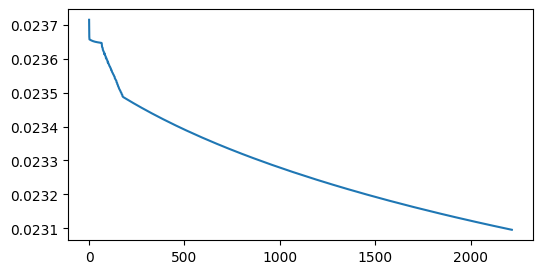

In [120]:
fig = plt.figure(figsize=(6, 3))
plt.plot([i for i in range(len(loss_traj))], loss_traj)
plt.show()

In [129]:
n_interpolation = 10
step = int(len(W)/n_interpolation)
sliced_indices = list(range(0, len(W) - 1, step))  
sliced_indices.append(len(W) - 1)                 
w_traj = W[sliced_indices]

model_vmp.set_w(w_traj)
t = torch.linspace(0, 1, 500).view(1, -1, 1)
z_trajs = model_vmp(t)

trajs = sphere.coordinates2ambient(z_trajs.view(-1, 2)).view(-1, 500, 3).detach().cpu()
z_trajs = sphere.ambinet2coordinates(trajs.view(-1, 3)).view(-1, 500, 2).detach().cpu()

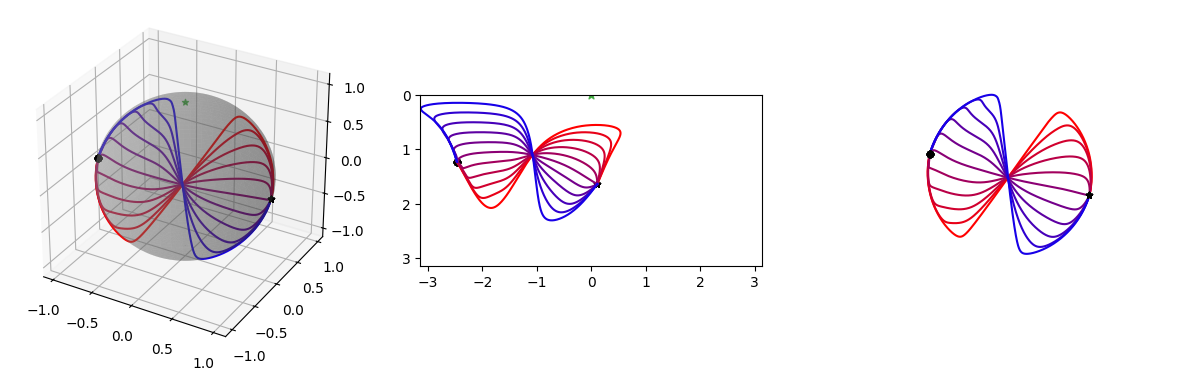

In [130]:
fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
sphere.add_sphere(ax1)

for i in range(len(trajs)):
    progress = i / len(trajs)
    ax1.plot(trajs[i, :, 0], trajs[i, :, 1], trajs[i, :, 2], c=[1-progress, 0, progress])
    ax1.scatter(trajs[i, 0, 0], trajs[i, 0, 1], trajs[i, 0, 2], c='k', marker='o', s=20, label='initial')
    ax1.scatter(trajs[i, -1, 0], trajs[i, -1, 1], trajs[i, -1, 2], c='k', marker='*', s=20, label='final')
ax1.scatter(0, 0, 1, c='tab:green', alpha=0.8, marker='*')

ax2 = fig.add_subplot(1, 3, 2)
sphere.add_coordinates(ax2)
for i in range(len(z_trajs)):
    progress = i / len(z_trajs)
    ax2.plot(z_trajs[i, :, 1], z_trajs[i, :, 0], c=[1-progress, 0, progress])
    ax2.scatter(z_trajs[i, 0, 1], z_trajs[i, 0, 0], c='k', marker='o', s=20, label='initial')
    ax2.scatter(z_trajs[i, -1, 1], z_trajs[i, -1, 0], c='k', marker='*', s=20, label='final')
ax2.scatter(0, 0, c='tab:green', alpha=0.8, marker='*')

ax0 = fig.add_subplot(1, 3, 3, projection='3d')
for i in range(len(trajs)):
    progress = i / len(trajs)
    ax0.plot(trajs[i, :, 0], trajs[i, :, 1], trajs[i, :, 2], c=[1-progress, 0, progress])
    ax0.scatter(trajs[i, 0, 0], trajs[i, 0, 1], trajs[i, 0, 2], c='k', marker='o', s=20, label='initial')
    ax0.scatter(trajs[i, -1, 0], trajs[i, -1, 1], trajs[i, -1, 2], c='k', marker='*', s=20, label='final')
ax0.axis('off')
ax0.axis('equal')

plt.show()

#### To generate video

In [ ]:
model_vmp.set_w(W)
t = torch.linspace(0, 1, 500).view(1, -1, 1)
z_trajs = model_vmp(t)

trajs = sphere.coordinates2ambient(z_trajs.view(-1, 2)).view(-1, 500, 3).detach().cpu()
z_trajs = sphere.ambinet2coordinates(trajs.view(-1, 3)).view(-1, 500, 2).detach().cpu()

video = []
for i in range(len(trajs)):
    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    sphere.add_sphere(ax1)

    
    progress = i / len(trajs)
    ax1.plot(trajs[i, :, 0], trajs[i, :, 1], trajs[i, :, 2], c=[1-progress, 0, progress])
    ax1.scatter(trajs[i, 0, 0], trajs[i, 0, 1], trajs[i, 0, 2], c='k', marker='o', s=20, label='initial')
    ax1.scatter(trajs[i, -1, 0], trajs[i, -1, 1], trajs[i, -1, 2], c='k', marker='*', s=20, label='final')
    ax1.scatter(0, 0, 1, c='tab:green', alpha=0.8, marker='*')

    ax2 = fig.add_subplot(1, 2, 2)
    sphere.add_coordinates(ax2)

    ax2.plot(z_trajs[i, :, 1], z_trajs[i, :, 0], c=[1-progress, 0, progress])
    ax2.scatter(z_trajs[i, 0, 1], z_trajs[i, 0, 0], c='k', marker='o', s=20, label='initial')
    ax2.scatter(z_trajs[i, -1, 1], z_trajs[i, -1, 0], c='k', marker='*', s=20, label='final')
    ax2.scatter(0, 0, c='tab:green', alpha=0.8, marker='*')

    # Save the figure to a buffer
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')  # Save to a buffer as a PNG image
    buf.seek(0)  # Rewind the buffer

    # Load the buffer into a PIL image and convert to NumPy array
    image = Image.open(buf)
    image_array = np.array(image)  # Convert to a NumPy array
    buf.close()  # Close the buffer

    video.append(image_array)
    plt.close()

In [ ]:
display_video(video, framerate=20)